In [1]:
import warnings
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import qutip
from scipy.sparse import dia_matrix
from collections import namedtuple


warnings.filterwarnings("ignore")
matplotlib.rcParams['xtick.direction'] = 'in' 
matplotlib.rcParams['ytick.direction'] = 'in' 
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['mathtext.fontset'] = 'cm'

In [2]:
N_list = np.array([100, 1000])
T_list = np.array([0.13, 0.015])

In [3]:
def ar_data_pre(n):
    data = np.load('a_r_datas/' + 'a_r_record_time50_n{}.npz'.format(n))['a_r_recording']
    return data[data[:, 0].argsort()][::-1][0:1][0][1]

# get_state
def get_state(q_state):
    expe_jx = qutip.expect(qutip.spin_Jx(n / 2), q_state)
    expe_jy = qutip.expect(qutip.spin_Jy(n / 2), q_state)
    expe_jz = qutip.expect(qutip.spin_Jz(n / 2), q_state)
    expe_jx2 = qutip.expect(qutip.spin_Jx(n / 2) * qutip.spin_Jx(n / 2), q_state)
    expe_jy2 = qutip.expect(qutip.spin_Jy(n / 2) * qutip.spin_Jy(n / 2), q_state)
    expe_jz2 = qutip.expect(qutip.spin_Jz(n / 2) * qutip.spin_Jz(n / 2), q_state)
    return [expe_jx, expe_jy, expe_jz, expe_jx2, expe_jy2, expe_jz2]


# Interaction Function
def interaction(action, q_state, current_state, u0, u1, u2, uf):
    state0 = current_state
    if action == 0:
        q_state = u0 * q_state  # non-pulse
    elif action == 1:
        q_state = u1 * q_state  # x-pulse
    elif action == 2:
        q_state = u2 * q_state  # y-pulse

    state1 = get_state(q_state)
    in_qfi = qfi(q_state, qutip.spin_Jz(n / 2), uf)
    record = namedtuple('record', ['q_state', 'qfi', 'action', 'state', 'next_state'])
    re = record
    [re.q_state, re.qfi, re.action, re.state, re.next_state] = [q_state, in_qfi, action, state0, state1]
    return re


def qfi(state, op, uf):
    # state: psi0, [Qobj];  O: operator, matrix
    psi_theta = uf * state
    psi_theta_d = -1j * op * psi_theta
    f_q_theta = 4 * (psi_theta_d.dag() * psi_theta_d - (psi_theta_d.dag() * psi_theta).norm() ** 2)
    return np.array(f_q_theta, dtype=np.float32)[0][0]


def compute_fig(N, T, actions):
    [s_size, a_size] = [6, 3]
    [n, nt, theta] = [N, 50, np.pi/2]
    dt = T/nt

    chi = 1
    h_0 = chi * (qutip.spin_Jz(n / 2) * qutip.spin_Jz(n / 2))

    u0 = (-1j * h_0 * dt).expm()
    ux = (-1j * np.pi / 2 * qutip.spin_Jx(n / 2)).expm()
    uy = (-1j * np.pi / 2 * qutip.spin_Jy(n / 2)).expm()
    u1 = ux * u0
    u2 = uy * u0

    uf = (-1j * theta * qutip.spin_Jz(n / 2)).expm()

    coherent = qutip.spin_coherent(n / 2, np.pi, 0)
    q_state_0 = uy * coherent  # initial state [Qobj]

    q_state = q_state_0  # initial state [Qobj]
    current_state = np.array(get_state(q_state=q_state))

    [states, qfis, rewards] = [np.zeros((nt, s_size)),
                               list(np.zeros(nt + 1)),
                               list(np.ones(nt))]

    for t in range(nt):  # total time_step = 50
        action = actions[t]
        actions[t] = action
        rec = interaction(action=action, q_state=q_state, current_state=current_state, 
                          u0=u0, u1=u1, u2=u2, uf=uf)
        q_state = rec.q_state  # Qobj
        if rec.qfi >= max(qfis):
            q_state_opt = q_state
            opt_spot = t
        current_state = rec.next_state
        states[t] = rec.state
        qfis[t] = rec.qfi
        
    xmax = max(qfis)/5*6.5

    np.savez('plot_state_data/plot_state_n{}'.format(N)+'.npz', qfis=qfis, opt_spot=opt_spot, T=T, xmax=xmax, actions=actions, 
             q_state_0=np.array(q_state_0).reshape(N+1), 
             q_state_opt=np.array(q_state_opt).reshape(N+1))


In [4]:
def plot_fig(N, n_axis, index):
    data = np.load('plot_state_data/plot_state_n{}'.format(N)+'.npz')
    qfis = data['qfis']
    opt_spot = data['opt_spot']
    T = data['T']
    xmax = data['xmax']
    actions = data['actions']
    q_state_0 = data['q_state_0']
    q_state_opt = data['q_state_opt']
    x = np.linspace(0, 50, 51)
    nt = 50
    dt = T/nt

    plt.subplot(n_axis, 3, int(3*index+1))
    plt.title('Evolution of QFI ($N = {}$)'.format(N))
    plt.plot(x[0:-1]*dt, qfis[0:-1], 'o-', linewidth=1, ms=4, zorder=1)
    plt.scatter(opt_spot*dt, qfis[opt_spot], color='firebrick', zorder=2)
    plt.plot([0, nt*dt], [max(qfis), max(qfis)], '--', label='QFI = {:.2f}'.format(max(qfis)))
    plt.xlabel('evolution time $t$')
    plt.ylabel('QFI')
    plt.xlim([0, nt*dt])
    plt.ylim([0, xmax])
    plt.legend(ncol=2, loc='upper center')

    plt.subplot(n_axis, 3, int(3*index+2))
    plt.title('Optimized Pulse Train $(N={})$'.format(N))
    x = actions * 1
    y = actions * 1
    for i in range(50):
        if x[i] == 2: x[i] = 0
        if y[i] == 1: y[i] = 0
    plt.bar(range(len(x)), x, label='$x$ pulse')
    plt.bar(range(len(y)), np.array(y)/2, label='$y$ pulse')
    plt.xlabel('time step')
    plt.ylabel('Pulse type')
    plt.xticks(range(0, 51, 5))
    plt.yticks([0])
    plt.xlim([0, 50])
    plt.ylim([0, 1.5])
    plt.grid(ls='--')
    plt.legend(ncol=2, loc='upper center')

    plt.subplot(n_axis, 3, int(3*index+3))
    plt.title('Optimized State $(N={})$'.format(N))
    plt.bar(np.array(range(N+1))-N/2, np.abs(np.array(qutip.Qobj(q_state_opt).unit()).reshape(N+1), dtype=np.float64), 
            width=1, color='tab:red', linewidth=1)
    plt.xlim([-N/2-0.5, N/2+0.5])
    if N == 20:
        plt.ylim([0, 0.7])
    if N == 30:
        plt.ylim([0, 0.6])
    plt.xlabel('$m$')

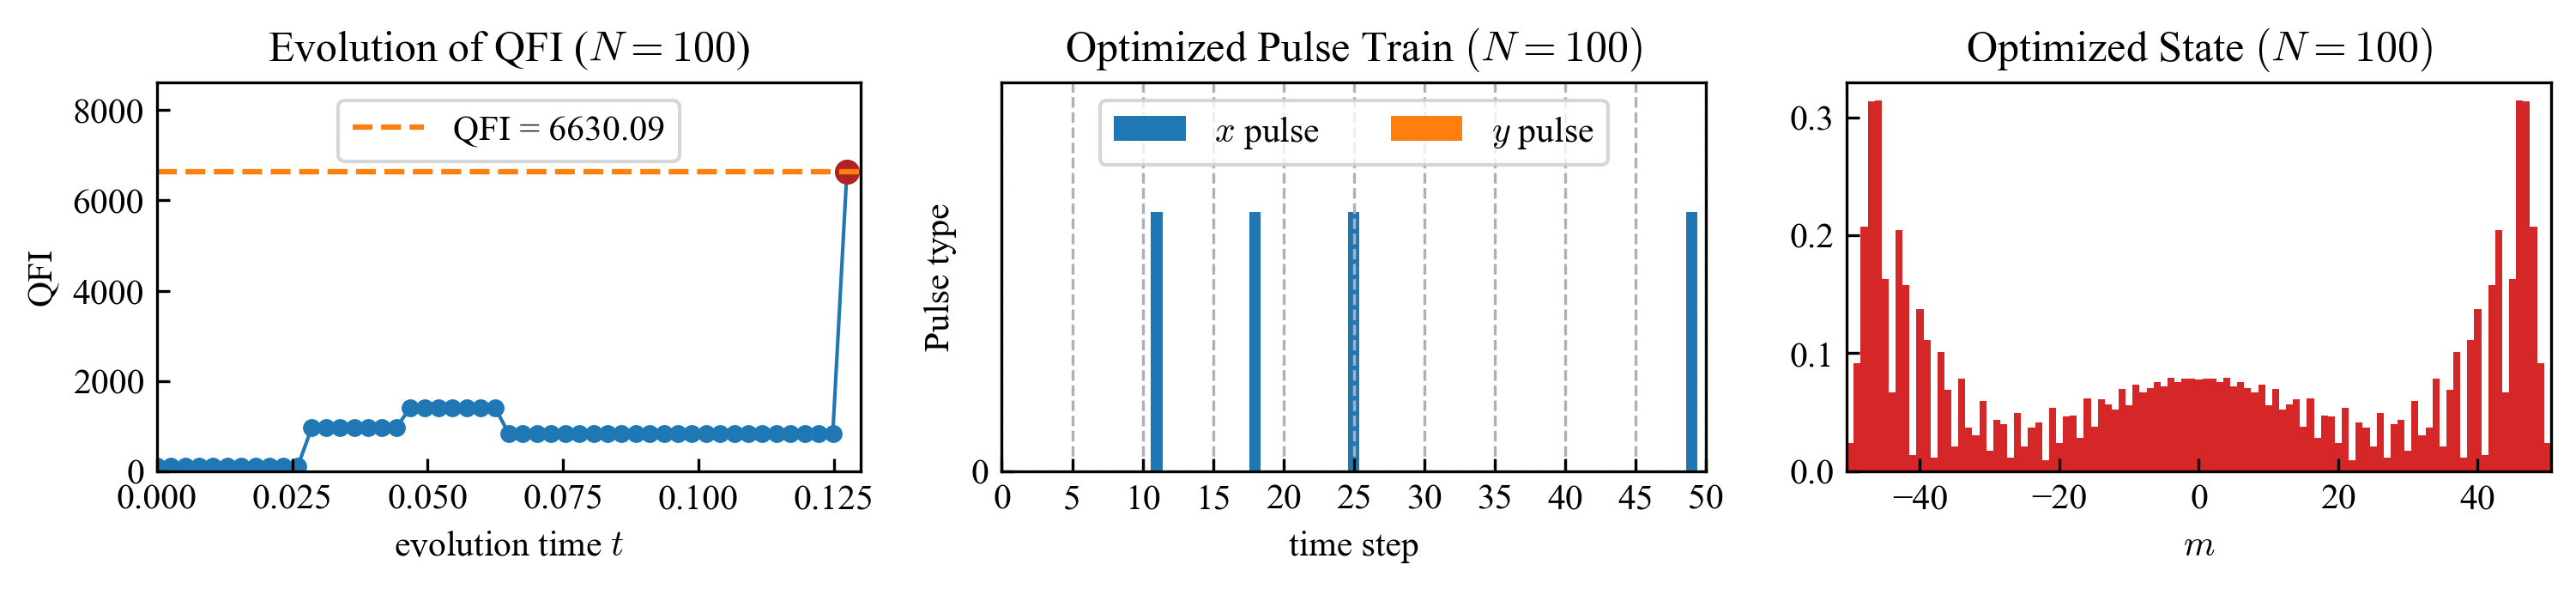

In [5]:
n = 100
T = 0.13
actions = ar_data_pre(n)
compute_fig(n, T, actions)
plt.figure(figsize=(12,2), dpi=300)
plot_fig(n, 1, 0)

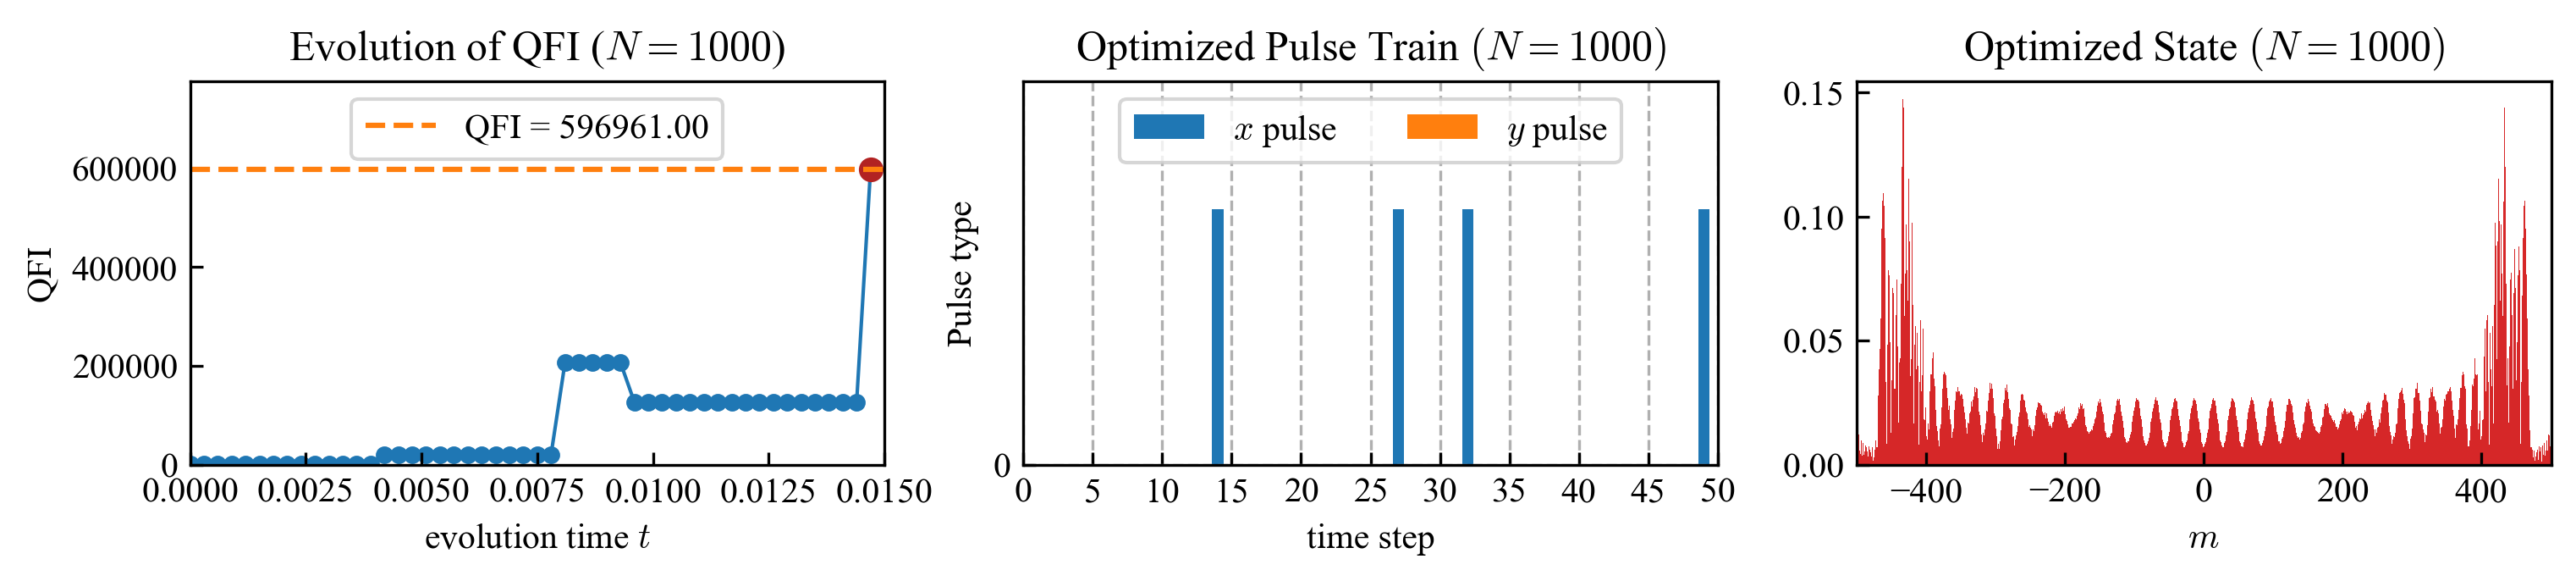

In [6]:
n = 1000
T = 0.015
actions = ar_data_pre(n)
compute_fig(n, T, actions)
plt.figure(figsize=(12,2), dpi=300)
plot_fig(n, 1, 0)